In [1]:
from data import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes,InsetPosition,mark_inset


import seaborn as sns
import networkx as nx
from lattice.lattice_template import *
from lattice.lattice_parallel_numba import *
from scipy.optimize import curve_fit

In [2]:
%ls

data.py    grid_run.py  ic_gen.py  parallel.py   Test.ipynb
datasets/  helper.py    lattice/   __pycache__/


In [3]:
fname = 'datasets/example_a-vs-pH_J:1.0,K:0.0_64x64_20000flips.hdf5'

reader = LatticeHDF5ReaderG(fname,50)

In [4]:
 
axes_font_size = 14
title_font_size = 14
label_font_size = 14
marker_size = 3
pH_line_width = 1

def rho_phase_plot_scatter(ax,df,reader,fig_let):
    ax.scatter(df['rho1'],df['rho2'],marker='.')
    ax.set_title('{2} J = {0}, K = {1}'.format(
            -reader.attrs['J'],reader.attrs['K'],fig_let),size = title_font_size,y=1.0,pad=-14)
    
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    ax.set_aspect('equal')
    ax.set_xlabel('$n_1$', size = label_font_size)
    ax.set_ylabel('$n_2$', size = label_font_size)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))


def rho_phase_plot_contour(ax,df,reader,fig_let,poptm,show_bar = True):
    window = 21
    poly_order = 7
    
    #cmap = cm.PuOr
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    ax.set_aspect('equal')
    ax.set_xlabel('$n_1$', size = label_font_size)
    ax.set_ylabel('$n_2$', size = label_font_size)
    
    
    levels = [-4,-3,-2,-1,0,2,4]
    cmap = sns.color_palette('Set2',len(levels),as_cmap=True) 
    #cmap = mcolors.ListedColormap(cmap)
    norm = mcolors.BoundaryNorm(levels, cmap.N)
    ax.tricontourf(df['rho1'],df['rho2'], df.index, cmap=cmap, norm=norm)
  
    #ax.set_title('J = {0}, K = {1}, {2}x{3}, {4} lattice flips'.format(
    #        reader.J,reader.K,reader.Lx,reader.Ly,reader.num_flips),size = 15)
    ax.set_title('{2} J = {0}, K = {1}'.format(
            -reader.attrs['J'],reader.attrs['K'],fig_let),size = title_font_size,y=1.0,pad=-14)

    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    dfp = df.reset_index()
    dfp = dfp.set_index('pH')
    #print(dfp)
    for i,tup in enumerate(dfp.groupby(level=0)):
        pH, data = tup
        if i%7 == 0:
            data = data.sort_values(by='a')
            #ax.plot(savgol_filter(data['rho1'],window, poly_order),
            #    savgol_filter(data['rho2'],window, poly_order),'k',label ='pH = {}'.format(pH))
            ax.plot(data['rho1'],data['rho2'],'k--',label ='pH = {}'.format(pH), lw = pH_line_width)
            
    #ax.legend()
    ax.tick_params(labelsize = axes_font_size)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    
    if show_bar:
        ax_left = 0.91
        ax_bottom = 0.25
        width = 0.05
        height = 0.65
        axin = ax.inset_axes([ax_left,ax_bottom,width,height])
        ax.text(ax_left - 0.15,ax_bottom + height/2 - 0.02, 'a', size = label_font_size)
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=axin)
        axin.yaxis.tick_left()
        
def rho_phase_plot_order(ax,df,reader,fig_let,show_bar = False):
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    
    norm = mcolors.Normalize(vmin=0, vmax=1.0)
    cmap = sns.cubehelix_palette(as_cmap=True,start = 0)
    #cmap = sns.color_palette("flare", as_cmap=True)
    ax.set_xlabel('$n_1$', size = label_font_size)
    ax.set_ylabel('$n_2$', size = label_font_size)
    #ax.set_title('Order Parameter, J = {0}, K = {1}, {2}x{3}, {4} lattice flips'.format(
    #        reader.J,reader.K,reader.Lx,reader.Ly,reader.num_flips),size = 18)
    ax.set_title('{2} J = {0}, K = {1}'.format(
            -reader.attrs['J'],reader.attrs['K'],fig_let),size = title_font_size,y=1.0,pad=-14)
    ax.tricontourf(df['rho1'],df['rho2'],np.abs(df['order']),levels = np.linspace(0,1,10),cmap = cmap, norm = norm)
    x = np.linspace(0,0.5,100)
    ax.plot(x,x,'k--')
    ax.set_aspect('equal')
    ax.tick_params(labelsize = axes_font_size)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    
    
    
    if show_bar:
        ax_left = 0.91
        ax_bottom = 0.25
        width = 0.05
        height = 0.65
        axin = ax.inset_axes([ax_left,ax_bottom,width,height])
        ax.text(ax_left - 0.15,ax_bottom + height/2 - 0.02, '$\\Delta_+$', size = label_font_size)
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=axin)
        axin.yaxis.tick_left()
        
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    return ax


def rho_phase_plot_dim(ax,df,reader,fig_let,show_bar = False):
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.0])
    norm = mcolors.Normalize(vmin=0, vmax=1.0)
    cmap = cm.magma
    ax.set_xlabel('$n_1$', size = label_font_size)
    ax.set_ylabel('$n_2$', size = label_font_size)
    #ax.set_title('Order Parameter, J = {0}, K = {1}, {2}x{3}, {4} lattice flips'.format(
    #        reader.J,reader.K,reader.Lx,reader.Ly,reader.num_flips),size = 18)
    ax.set_title('{2} J = {0}, K = {1}'.format(
            -reader.attrs['J'],reader.attrs['K'],fig_let),size = title_font_size,y=1.0,pad=-14)
    ax.tricontourf(df['rho1'],df['rho2'],np.abs(df['com_idx']),cmap = cmap, norm = norm)
    x = np.linspace(0,0.5,100)
    ax.plot(x,x,'g-')
    ax.set_aspect('equal')
    ax.tick_params(labelsize = axes_font_size)
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    
    
    
    if show_bar:
        ax_left = 0.91
        ax_bottom = 0.25
        width = 0.05
        height = 0.65
        axin = ax.inset_axes([ax_left,ax_bottom,width,height])
        ax.text(ax_left - 0.17,ax_bottom + height/2 - 0.02, '$\\sigma_{ma}$', size = label_font_size)
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=axin)
        axin.yaxis.tick_left()
        
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    return ax
    #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

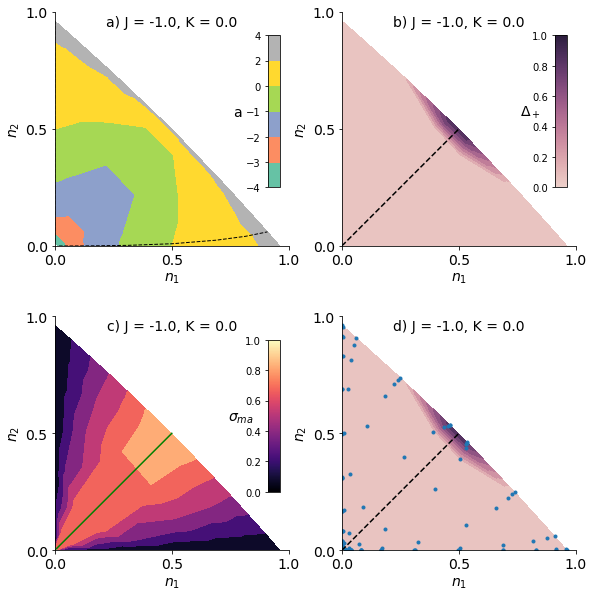

In [6]:
fig, _axs = plt.subplots(nrows=2, ncols=2,figsize=(6.8,6.8))
fig.subplots_adjust(hspace=0.3)
ax = _axs.flatten()

#a) j1 contour
df = reader.table.copy()
df.set_index('a',inplace=True)


rho_phase_plot_contour(ax[0],df,reader,'a)', (0.16,0.18), show_bar=True)
rho_phase_plot_order(ax[1],df,reader,'b)', show_bar=True)

rho_phase_plot_dim(ax[2],df,reader,'c)', show_bar=True)

rho_phase_plot_order(ax[3],df,reader,'d)')
rho_phase_plot_scatter(ax[3],df,reader,'d)')

plt.subplots_adjust(bottom=0, right=1.2, top=1.1)